In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/age_gender.csv")

## Data Cleaning

In [3]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [4]:
# label_to_age = {
#     0: "0-6 years old",
#     1: "7-12 years old",
#     2: "13-19 years old",
#     3: "20-30 years old",
#     4: "31-45 years old",
#     5: "46-55 years old",
#     6: "56-66 years old",
#     7: "67-80 years old",
#     8: "81+ years old",
# }

age_cutoffs = [-1, 6, 12, 19, 30, 45, 55, 66, 80, 120]
# age_cutoffs = [-1, 5, 10, 15, 22, 30, 45, 60, 80, 120]
label_names = [f"{age_cutoffs[i]+1}-{age_cutoffs[i+1]} years old" for i in range(len(age_cutoffs)-2)]
label_names.append("81+ years old")

In [5]:
df["age_group"] = pd.cut(df["age"], bins=age_cutoffs, labels=range(len(label_names)))
df

,age,ethnicity,gender,img_name,pixels,age_group
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...,0
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...,0
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...,0
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...,0
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...,0
...,...,...,...,...,...,...
23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...,8
23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...,8
23702,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...,8
23703,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...,8


In [6]:
X_df = df["pixels"]
X_df = X_df\
  .apply(lambda x: x.split(' '))\
  .apply(lambda x: list(map(int, x)))\
  .tolist()

In [7]:
X = np.array(X_df).astype('float32')/255
X = X.reshape(-1, 1, 48, 48)
X.shape

(23705, 1, 48, 48)

In [8]:
X_3 = np.repeat(X, 3, axis=1)
X_3.shape

(23705, 3, 48, 48)

In [9]:
y_df = df["age_group"]

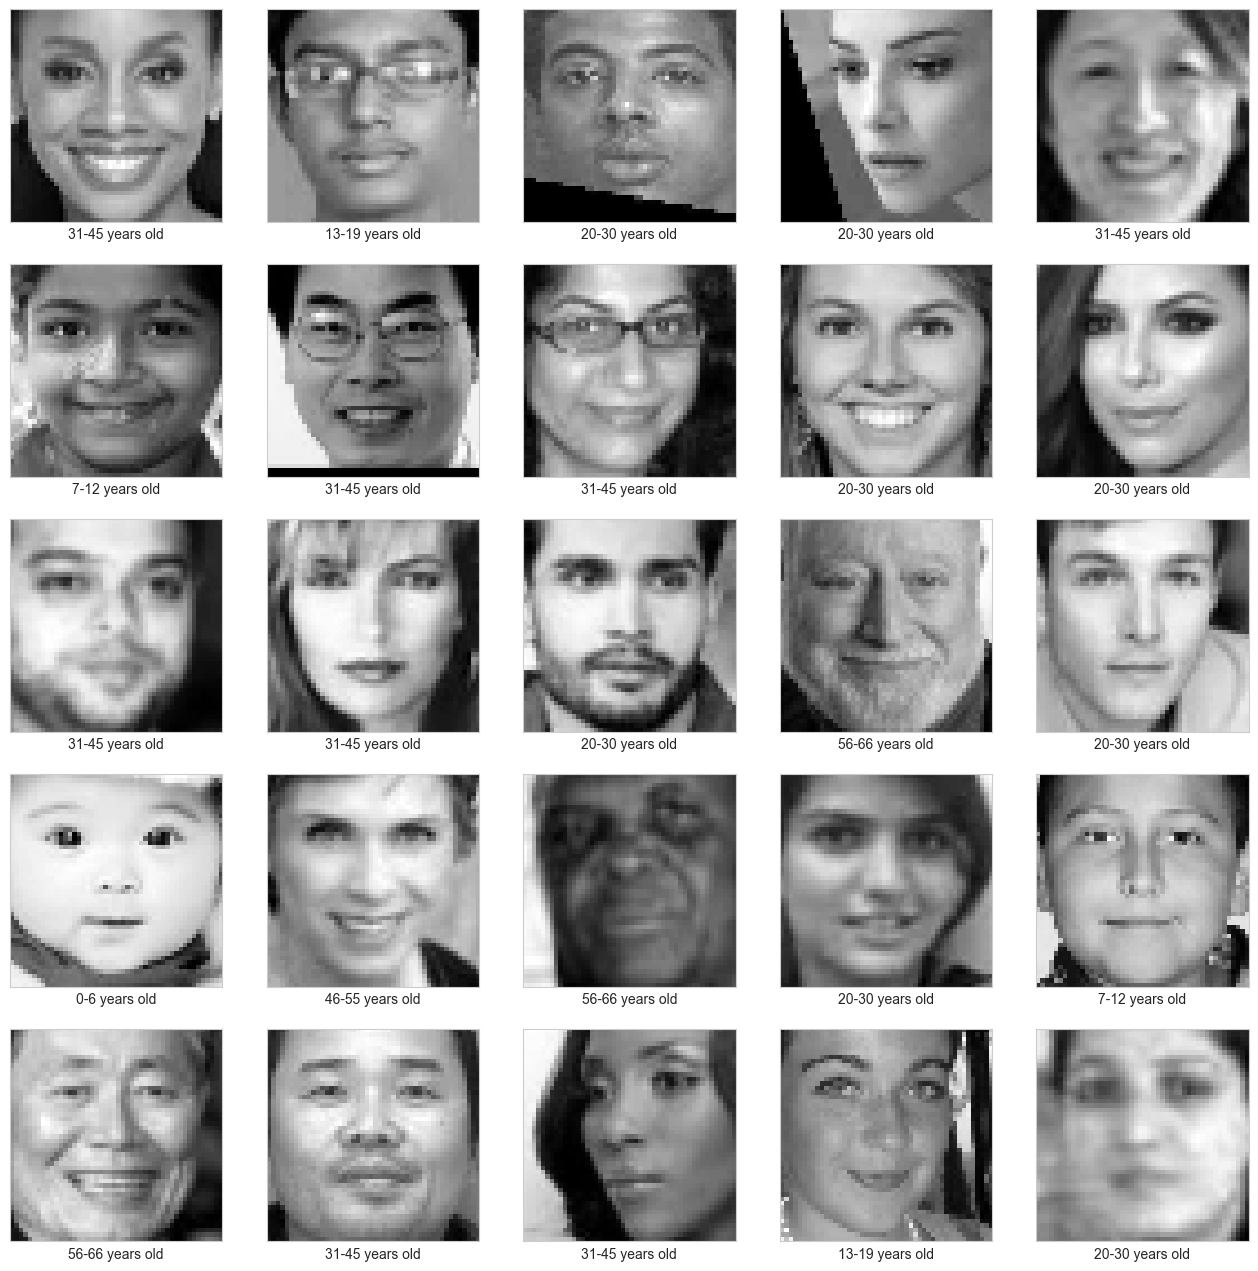

In [147]:
fig, ax = plt.subplots(5, 5, figsize=(16, 16))
for i in range(5):
  for j in range(5):
    a = ax[i][j]
    r_i = np.random.randint(0, len(X))
    x = X[r_i,0]
    a.imshow(x, cmap="grey")
    a.set_xticks([])
    a.set_yticks([])
    a.grid(False)
    a.set_xlabel(label_names[y_df[r_i]])

In [11]:
# y = np.array(df["age"]).reshape((-1, 1))
# y.shape

In [12]:
y = np.array(df["age_group"])
y.shape

(23705,)

## Age Classification

In [13]:
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam, lr_scheduler, SGD

from sklearn.model_selection import train_test_split
import pickle

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Training on", device)

Training on cuda


### Train Test Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_3, y, test_size=0.1, random_state=16)

In [16]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [17]:
batch_size=256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset)

### Fine-tuning ResNet18

In [182]:
model_name = "age_classifier_6"
model_weights_filename = f"../models/{model_name}.pth"
loss_history_filename = f"../models/{model_name}_loss_history.pkl"
# model_weights_filename = "/content/drive/MyDrive/MachineLearningWeights/pt_rn18_finetuned_2.pth"
# training_loss_history_filename = "/content/drive/MyDrive/MachineLearningWeights/training_history.pkl"

In [170]:
model = models.resnet18(weights='IMAGENET1K_V1')
# model.fc = nn.Linear(model.fc.in_features, len(label_names))
model = model.to(device)

In [171]:
def freeze_first_layers(k, model=model):
    for i, (name, layer) in enumerate(model.named_children()):
        for param in layer.parameters():
            param.requires_grad = i >= k

In [21]:
freeze_first_layers(6)

In [22]:
list(model.named_children())

[('conv1',
  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)),
 ('bn1',
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 ('relu', ReLU(inplace=True)),
 ('maxpool',
  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)),
 ('layer1',
  Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

In [172]:
# model.layer3 = nn.Identity()
model.layer4 = nn.Identity()

model.layer3 = nn.Sequential(
    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
).to(device)
# model.layer4 = nn.Sequential(
#     nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
#     nn.BatchNorm2d(512),
#     nn.ReLU(),
# ).to(device)
model.fc = nn.Linear(256, len(label_names)).to(device)
# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, 1000),
#     nn.Dropout(0.5),
#     nn.Linear(1000, len(label_names)),
# ).to(device)

# model.fc = nn.Linear(model.fc.in_features, len(label_names)).to(device)

In [24]:
list(model.named_children())

[('conv1',
  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)),
 ('bn1',
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 ('relu', ReLU(inplace=True)),
 ('maxpool',
  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)),
 ('layer1',
  Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

In [178]:
def load_model(model=model, model_weights_filename=model_weights_filename, loss_history_filename=loss_history_filename):
    model.load_state_dict(torch.load(model_weights_filename))
    # Load loss history
    with open(loss_history_filename, "rb") as f:
        loss_dict = pickle.load(f)
        loss_train, loss_valid = loss_dict["loss_train"], loss_dict["loss_valid"]
    model.eval()
    return loss_train, loss_valid

In [179]:
def save_model(loss_train, loss_valid, model=model, model_weights_filename=model_weights_filename, loss_history_filename=loss_history_filename):
    model.eval()
    # Save model weights
    torch.save(model.state_dict(), model_weights_filename)
    # Save loss history
    loss_dict = {"loss_train": loss_train, "loss_valid": loss_valid}
    with open(loss_history_filename, "wb") as f:
        pickle.dump(loss_dict, f)

In [180]:
def train_model(criterion, optimizer, scheduler=None, num_epochs=30, model=model, train_loader=train_loader, model_weights_filename=model_weights_filename, loss_history_filename=loss_history_filename):
    loss_train, loss_valid = [], []
    
    for epoch in range(num_epochs):
        running_loss = 0
    
        i = 0
        model.train()
        for inputs, labels in train_loader:
            i += 1
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            
            # Gather data and report
            running_loss += loss.item()
        
        if scheduler:
            scheduler.step()
        model.eval()
        
        last_loss = running_loss / i # loss per batch
        loss_train.append(last_loss)
        acc_train = (outputs.argmax(dim=1) == labels).float().mean().item()
        
        with torch.no_grad():
            outputs = model(X_test_tensor)
            loss = criterion(outputs, y_test_tensor)
            loss_valid.append(loss.item())
            acc_valid = (outputs.argmax(dim=1) == y_test_tensor).float().mean().item()
        
        print(f"Epoch {epoch+1}/{num_epochs}    train loss: {last_loss:.4f}    train accuracy: {acc_train:.4f}    validation loss: {loss_valid[-1]:.4f}    validation accuracy: {acc_valid:.4f}")
    
    save_model(loss_train, loss_valid, model_weights_filename=model_weights_filename, loss_history_filename=loss_history_filename)

In [173]:
class_weights = y_train_tensor.bincount().float()
class_weights = 1 - class_weights / class_weights.sum()
class_weights = class_weights.to(device)
class_weights

tensor([0.8937, 0.9616, 0.9504, 0.6602, 0.7713, 0.9050, 0.9267, 0.9542, 0.9770],
       device='cuda:0')

In [181]:
import pickle

criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
# exp_lr_scheduler = None
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
num_epochs = 30

try:
    loss_train, loss_valid = load_model()
except FileNotFoundError:
    train_model(criterion, optimizer, scheduler=exp_lr_scheduler, num_epochs=num_epochs)

Epoch 1/30    train loss: 1.5299    train accuracy: 0.6047    validation loss: 1.3174    validation accuracy: 0.5162
Epoch 2/30    train loss: 1.1246    train accuracy: 0.5814    validation loss: 1.1264    validation accuracy: 0.5563
Epoch 3/30    train loss: 1.0141    train accuracy: 0.5465    validation loss: 1.0559    validation accuracy: 0.5875
Epoch 4/30    train loss: 0.9285    train accuracy: 0.6279    validation loss: 1.1037    validation accuracy: 0.5892
Epoch 5/30    train loss: 0.8610    train accuracy: 0.6860    validation loss: 1.1254    validation accuracy: 0.5841
Epoch 6/30    train loss: 0.7686    train accuracy: 0.7326    validation loss: 1.0110    validation accuracy: 0.5833
Epoch 7/30    train loss: 0.7192    train accuracy: 0.7093    validation loss: 0.9844    validation accuracy: 0.6086
Epoch 8/30    train loss: 0.6705    train accuracy: 0.7558    validation loss: 1.4676    validation accuracy: 0.4757
Epoch 9/30    train loss: 0.6135    train accuracy: 0.7791    va

KeyboardInterrupt: 

In [30]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    loss = criterion(outputs, y_test_tensor)
    acc = (outputs.argmax(dim=1) == y_test_tensor).float().mean().item()
    print(f"test loss: {loss.item():.4f}    test accuracy: {acc:.4f}")

test loss: 1.4110    test accuracy: 0.6019


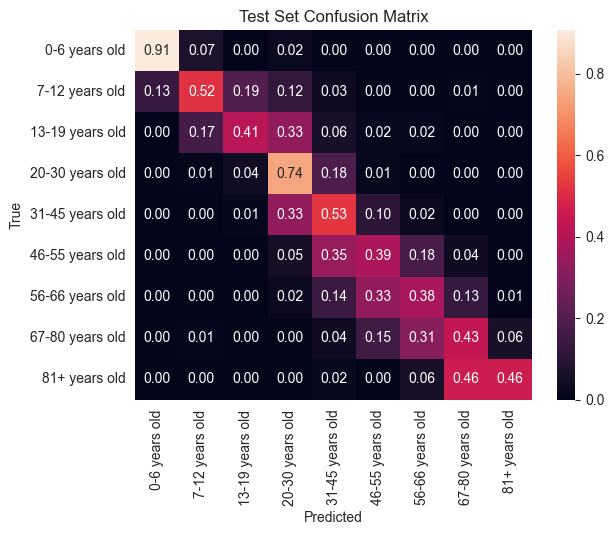

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(X, y, title=""):
    model.eval()
    outputs = model(X)
    y_pred = outputs.argmax(dim=1).cpu().numpy()
    y_true = y.cpu().numpy()
    
    cm = confusion_matrix(y_true, y_pred, normalize="true")
    plt.title(title)
    ax = sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=label_names, yticklabels=label_names)
    ax.set(xlabel="Predicted", ylabel="True")
    plt.show()

plot_confusion_matrix(X_test_tensor, y_test_tensor, title="Test Set Confusion Matrix")

## Visualize the different loss distributions between retain and forget

In [32]:
def compute_losses(model, loader):
    """Auxiliary function to compute per-sample losses"""
    criterion = nn.CrossEntropyLoss(reduction="none")
    losses = []
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.extend(loss.detach().cpu().numpy())
    return np.array(losses)

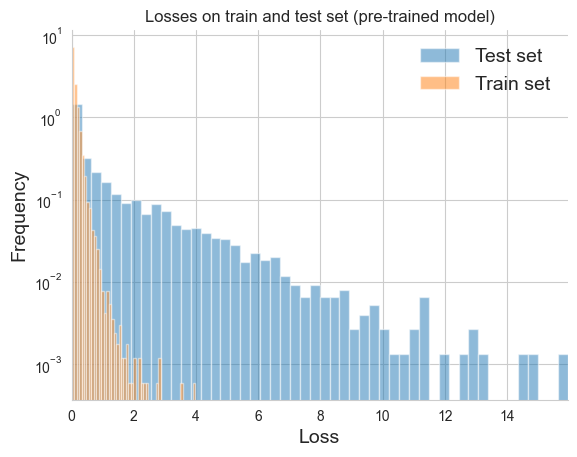

In [38]:
train_losses = compute_losses(model, train_loader)
test_losses = compute_losses(model, test_loader)

# plot losses on train and test set
plt.title("Losses on train and test set (pre-trained model)")
plt.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(train_losses, density=True, alpha=0.5, bins=50, label="Train set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

## Unlearning

### Class Unlearning

In [33]:
from torch.utils.data import Subset
class_to_forget = 0
forget_dataset = Subset(train_dataset, np.where(y_train == class_to_forget)[0])
retain_dataset = Subset(train_dataset, np.where(y_train != class_to_forget)[0])
forget_loader = DataLoader(forget_dataset, batch_size=batch_size, shuffle=True)
retain_loader = DataLoader(retain_dataset, batch_size=batch_size, shuffle=True)

In [34]:
len(retain_dataset), len(forget_dataset)

(19066, 2268)

### Membership Inference Attack

Logistic regression that predicts whether a datapoint was in the training set based on its loss

In [35]:
from sklearn import linear_model, model_selection

def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

In [46]:
def compute_mia_accuracy():
    forget_losses = compute_losses(model, forget_loader)
    
    # Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
    np.random.shuffle(forget_losses)
    forget_losses = forget_losses[: len(test_losses)]
    
    samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)
    
    mia_scores = simple_mia(samples_mia, labels_mia)
    return mia_scores.mean()

print(
    f"The MIA has an accuracy of {compute_mia_accuracy():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.796 on forgotten vs unseen images


### Selective Synaptic Dampening

In [42]:
class SSD:

    def __init__(
        self,
        model,
        optimizer=None,
        selection_weight=50,
        dampening=0.1,
        freeze_layers=0,
        device="cuda" if torch.cuda.is_available() else "cpu",
        is_starter=False,
    ):
        self.model = model
        self.optimizer = optimizer
        self.selection_weight = selection_weight
        self.dampening = dampening
        self.freeze_layers = freeze_layers
        self.device = device
        if not optimizer:
            self.optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
            # self.optimizer = optim.Adam(model.parameters(), lr=1e-2)
        self.is_starter = is_starter

    def fisher(self, dataloader: DataLoader):
        criterion = nn.CrossEntropyLoss()
        fim = {
            name: torch.zeros_like(weight, device=weight.device)
            for name, weight in self.model.named_parameters()
        }
        for batch in dataloader:
            inputs, targets = batch
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            for name, weight in self.model.named_parameters():
                if weight.grad is not None:
                    fim[name].data += weight.grad.data ** 2
        for name, weight in self.model.named_parameters():
            fim[name].data /= len(dataloader)
        return fim

    def dampen(self, original_fim, forget_fim):
        with torch.no_grad():
            for (name, param), importance, f_importance in zip(
                self.model.named_parameters(),
                original_fim.values(),
                forget_fim.values(),
            ):
                mask = f_importance > self.selection_weight * importance
                dampening_weights = torch.clamp(self.dampening * importance[mask] / f_importance[mask], max=1)
                param[mask] *= dampening_weights

    def freeze(self):
        for i, (name, layer) in enumerate(model.named_children()):
            for param in layer.parameters():
                param.requires_grad = i >= self.freeze_layers

    def unlearn(self, full_dl: DataLoader, forget_dl: DataLoader):
        self.freeze()
        self.model = self.model.eval()
        original_fim = self.fisher(full_dl)
        forget_fim = self.fisher(forget_dl)
        self.dampen(original_fim, forget_fim)
        self.model = self.model.eval()

In [43]:
load_model()

([1.5359257700897397,
  1.1340665632770175,
  1.0120830684900284,
  0.9336212085826057,
  0.861969666821616,
  0.7688034893501372,
  0.7147001602819988,
  0.6646668463945389,
  0.6094146101247697,
  0.5501582856689181,
  0.4633382008898826,
  0.42100116575048085,
  0.38307039049409686,
  0.34825024008750916,
  0.3099307322076389,
  0.26256673215400606,
  0.24293078588587896,
  0.22408921129646756,
  0.21014083975127765,
  0.19140692906720297,
  0.17700452410749026,
  0.16788303426333837,
  0.1617522438367208,
  0.1549516777020125,
  0.1491495134042842,
  0.14337432677192347,
  0.13902800361670198,
  0.13775091396556013,
  0.1362429829757838,
  0.1320357777710472],
 [1.2512518167495728,
  1.0806188583374023,
  1.0767583847045898,
  1.2912708520889282,
  1.0300660133361816,
  1.0236873626708984,
  1.2023944854736328,
  1.011340618133545,
  1.0710593461990356,
  1.1172822713851929,
  1.0488595962524414,
  1.1107584238052368,
  1.149673581123352,
  1.2704896926879883,
  1.256240725517273,


In [186]:
def compute_loss_and_accuracy(model, loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    loss = 0
    correct_predictions = 0
    total_predictions = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss += criterion(outputs, labels).item()
        predicted_labels = torch.argmax(outputs, dim=1)
        total_predictions += labels.shape[0]
        correct_predictions += int(torch.sum(predicted_labels == labels))
    loss = loss / len(loader)
    accuracy = correct_predictions / total_predictions
    return loss, accuracy

def display_stats(model=model):
    for name, loader in zip(["Train", "Retain", "Forget", "Test"], [train_loader, retain_loader, forget_loader, test_loader]):
        loss, accuracy = compute_loss_and_accuracy(model, loader)
        print(f"{name} loss: {loss:.4f}    {name} accuracy: {accuracy:.4f}")
    print(f"MIA accuracy: {compute_mia_accuracy():.3f}")

In [45]:
print("Before SSD")
display_stats()

Before SSD
Train loss: 0.1099    Train accuracy: 0.9926
Retain loss: 0.1195    Retain accuracy: 0.9921
Forget loss: 0.0302    Forget accuracy: 0.9965
Test loss: 1.3557    Test accuracy: 0.6019
MIA accuracy: 0.800


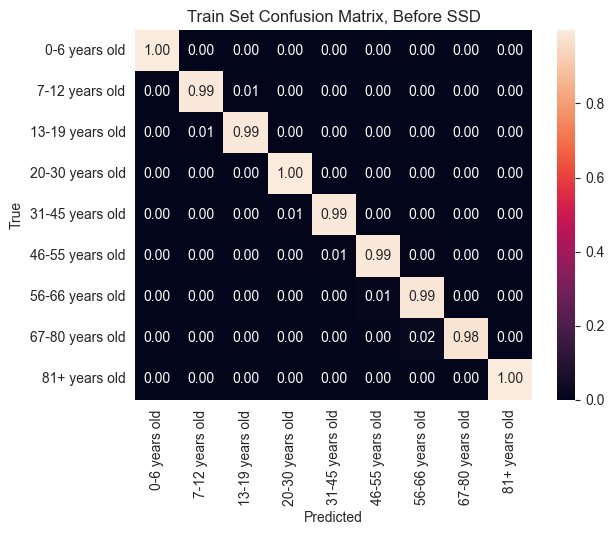

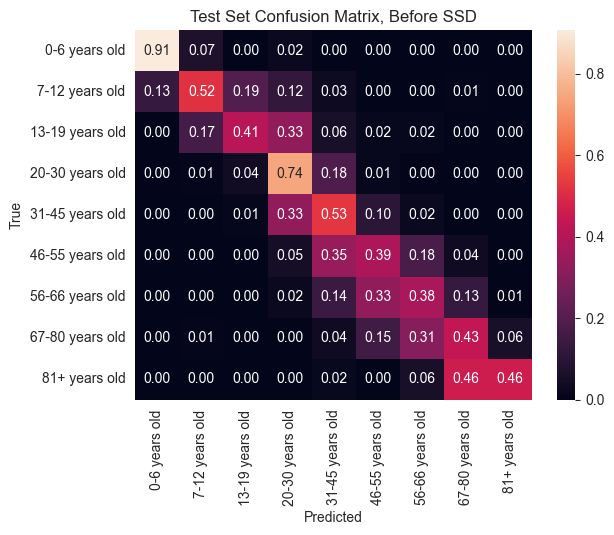

In [47]:
plot_confusion_matrix(X_train_tensor, y_train_tensor, title="Train Set Confusion Matrix, Before SSD")
plot_confusion_matrix(X_test_tensor, y_test_tensor, title="Test Set Confusion Matrix, Before SSD")

In [48]:
SSD(model, selection_weight=150, dampening=0.1).unlearn(train_loader, forget_loader)

In [49]:
print("After SSD On 0-6 Age Class")
display_stats()

After SSD On 0-6 Age Class
Train loss: 0.8288    Train accuracy: 0.8868
Retain loss: 0.1174    Retain accuracy: 0.9923
Forget loss: 6.8292    Forget accuracy: 0.0000
Test loss: 1.9699    Test accuracy: 0.5209
MIA accuracy: 0.919


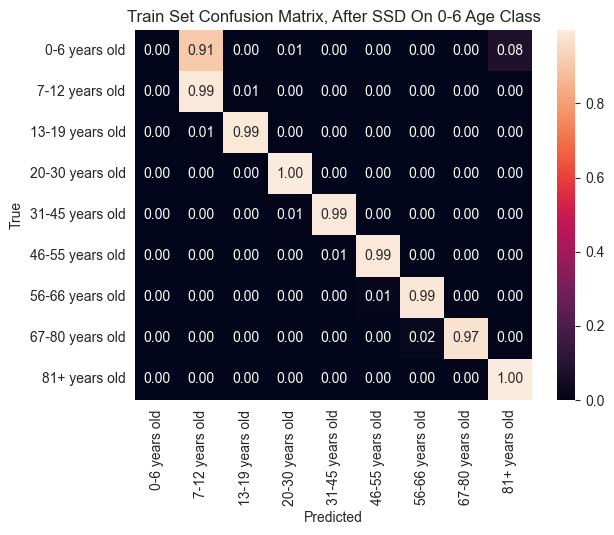

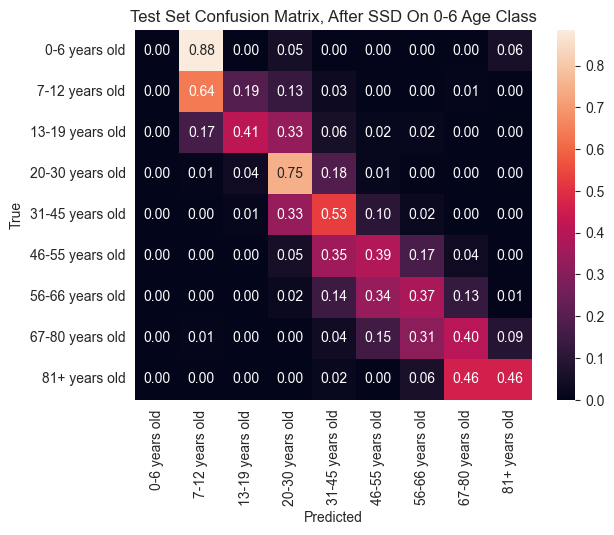

In [50]:
plot_confusion_matrix(X_train_tensor, y_train_tensor, title="Train Set Confusion Matrix, After SSD On 0-6 Age Class")
plot_confusion_matrix(X_test_tensor, y_test_tensor, title="Test Set Confusion Matrix, After SSD On 0-6 Age Class")

## Random Unlearning

In [162]:
# random unlearning

from torch.utils.data import random_split
retain_dataset, forget_dataset = random_split(train_dataset, [0.8, 0.2])
retain_loader = DataLoader(retain_dataset, batch_size=batch_size, shuffle=True)
forget_loader = DataLoader(forget_dataset, batch_size=batch_size, shuffle=True)

### Baseline

In [185]:
baseline_name = "baseline_age_classifier"
baseline_filename = f"../models/{baseline_name}.pth"
baseline_loss_filename = f"../models/{baseline_name}_loss_history.pkl"

baseline = models.resnet18(weights='IMAGENET1K_V1')
baseline = baseline.to(device)
baseline.layer3 = nn.Sequential(
    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
).to(device)
baseline.layer4 = nn.Identity()
baseline.fc = nn.Linear(256, len(label_names)).to(device)

# freeze_first_layers(6, model=baseline)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = SGD(baseline.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
num_epochs = 30

try:
    loss_train, loss_valid = load_model(model=baseline, model_weights_filename=baseline_filename, loss_history_filename=baseline_loss_filename)
except FileNotFoundError:
    train_model(
        criterion,
        optimizer,
        scheduler=exp_lr_scheduler,
        num_epochs=num_epochs,
        model=baseline,
        train_loader=retain_loader,
        model_weights_filename=baseline_filename,
        loss_history_filename=baseline_loss_filename,
    )

Epoch 1/30    train loss: 1.5507    train accuracy: 0.4942    validation loss: 1.2943    validation accuracy: 0.5150
Epoch 2/30    train loss: 1.1466    train accuracy: 0.5407    validation loss: 1.1331    validation accuracy: 0.5327
Epoch 3/30    train loss: 1.0233    train accuracy: 0.5756    validation loss: 1.0548    validation accuracy: 0.5706
Epoch 4/30    train loss: 0.9449    train accuracy: 0.5930    validation loss: 0.9916    validation accuracy: 0.5938
Epoch 5/30    train loss: 0.8773    train accuracy: 0.6802    validation loss: 0.9803    validation accuracy: 0.5964
Epoch 6/30    train loss: 0.8016    train accuracy: 0.6802    validation loss: 0.9611    validation accuracy: 0.5960
Epoch 7/30    train loss: 0.7555    train accuracy: 0.6802    validation loss: 1.0300    validation accuracy: 0.5875
Epoch 8/30    train loss: 0.7081    train accuracy: 0.6860    validation loss: 1.1193    validation accuracy: 0.5479
Epoch 9/30    train loss: 0.6631    train accuracy: 0.6919    va

In [188]:
display_stats(model=baseline)

Train loss: 0.4317    Train accuracy: 0.8937
Retain loss: 0.1889    Retain accuracy: 0.9723
Forget loss: 1.3973    Forget accuracy: 0.5792
Test loss: 1.3339    Test accuracy: 0.5778
MIA accuracy: 0.643


In [101]:
load_model()

([1.5359257700897397,
  1.1340665632770175,
  1.0120830684900284,
  0.9336212085826057,
  0.861969666821616,
  0.7688034893501372,
  0.7147001602819988,
  0.6646668463945389,
  0.6094146101247697,
  0.5501582856689181,
  0.4633382008898826,
  0.42100116575048085,
  0.38307039049409686,
  0.34825024008750916,
  0.3099307322076389,
  0.26256673215400606,
  0.24293078588587896,
  0.22408921129646756,
  0.21014083975127765,
  0.19140692906720297,
  0.17700452410749026,
  0.16788303426333837,
  0.1617522438367208,
  0.1549516777020125,
  0.1491495134042842,
  0.14337432677192347,
  0.13902800361670198,
  0.13775091396556013,
  0.1362429829757838,
  0.1320357777710472],
 [1.2512518167495728,
  1.0806188583374023,
  1.0767583847045898,
  1.2912708520889282,
  1.0300660133361816,
  1.0236873626708984,
  1.2023944854736328,
  1.011340618133545,
  1.0710593461990356,
  1.1172822713851929,
  1.0488595962524414,
  1.1107584238052368,
  1.149673581123352,
  1.2704896926879883,
  1.256240725517273,


In [102]:
print("Before SSD")
display_stats()

Before SSD
Train loss: 0.1100    Train accuracy: 0.9926
Retain loss: 0.1097    Retain accuracy: 0.9925
Forget loss: 0.1116    Forget accuracy: 0.9930
Test loss: 1.3557    Test accuracy: 0.6019
MIA accuracy: 0.729


In [103]:
SSD(model, selection_weight=10, dampening=0.1).unlearn(train_loader, forget_loader)

In [104]:
print("After SSD On 20% of Train Set")
display_stats()

After SSD On 20% of Train Set
Train loss: 0.1099    Train accuracy: 0.9926
Retain loss: 0.1098    Retain accuracy: 0.9925
Forget loss: 0.1115    Forget accuracy: 0.9930
Test loss: 1.3557    Test accuracy: 0.6019
MIA accuracy: 0.729


In [148]:
load_model()
SSD(model, selection_weight=2, dampening=0.5).unlearn(train_loader, forget_loader)
print("After SSD On 20% of Train Set, Aggressive")
display_stats()

After SSD On 20% of Train Set, Aggressive
Train loss: 0.2426    Train accuracy: 0.9253
Retain loss: 0.2406    Retain accuracy: 0.9252
Forget loss: 0.2497    Forget accuracy: 0.9255
Test loss: 1.3977    Test accuracy: 0.5943
MIA accuracy: 0.668


In [100]:
load_model()
SSD(model, selection_weight=1, dampening=0.5, freeze_layers=6).unlearn(train_loader, forget_loader)
print("After SSD On 20% of Train Set, Freezing First 6 Layers")
display_stats()

After SSD On 20% of Train Set, Freezing First 6 Layers
Train loss: 1.4852    Train accuracy: 0.5757
Retain loss: 1.4695    Retain accuracy: 0.5783
Forget loss: 1.5394    Forget accuracy: 0.5649
Test loss: 2.2792    Test accuracy: 0.4066
MIA accuracy: 0.560


In [96]:
def optim_freeze_first_k(k, criterion, optimizer, epochs=10):
    for i, (name, layer) in enumerate(model.named_children()):
        for param in layer.parameters():
            param.requires_grad = i >= k
    model.train()
    for epoch in range(epochs):
        for inputs,labels in retain_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
def optim_last_k(k, criterion, optimizer, epochs=10):
    freeze_first = len(list(model.named_children())) - k
    optim_freeze_first_k(k, criterion, optimizer, epochs)

In [121]:
load_model()
optim_freeze_first_k(6, criterion, optimizer, epochs=20)
print("After Retrain, Freezing First 6 Layers")
display_stats()

After Retrain, Freezing First 6 Layers
Train loss: 0.0302    Train accuracy: 0.9942
Retain loss: 0.0240    Retain accuracy: 0.9963
Forget loss: 0.0542    Forget accuracy: 0.9859
Test loss: 2.2437    Test accuracy: 0.5888
MIA accuracy: 0.774


In [122]:
load_model()
SSD(model, selection_weight=1, dampening=0.5, freeze_layers=6).unlearn(train_loader, forget_loader)
optim_freeze_first_k(6, criterion, optimizer, epochs=20)
print("After SSD + Retrain, Freezing First 6 Layers")
display_stats()

After SSD + Retrain, Freezing First 6 Layers
Train loss: 0.0356    Train accuracy: 0.9938
Retain loss: 0.0287    Retain accuracy: 0.9963
Forget loss: 0.0638    Forget accuracy: 0.9838
Test loss: 2.1213    Test accuracy: 0.5922
MIA accuracy: 0.758


In [123]:
load_model()
optim_freeze_first_k(0, criterion, optimizer, epochs=20)
print("After Retrain, No Freezing")
display_stats()

After Retrain, No Freezing
Train loss: 0.1936    Train accuracy: 0.9445
Retain loss: 0.0153    Retain accuracy: 0.9965
Forget loss: 0.9084    Forget accuracy: 0.7363
Test loss: 1.9409    Test accuracy: 0.5871
MIA accuracy: 0.560


In [124]:
load_model()
SSD(model, selection_weight=1, dampening=0.5, freeze_layers=0).unlearn(train_loader, forget_loader)
optim_freeze_first_k(0, criterion, optimizer, epochs=20)
print("After SSD + Retrain, No Freezing")
display_stats()

After SSD + Retrain, No Freezing
Train loss: 0.2964    Train accuracy: 0.9235
Retain loss: 0.0185    Retain accuracy: 0.9965
Forget loss: 1.4092    Forget accuracy: 0.6317
Test loss: 1.8760    Test accuracy: 0.5803
MIA accuracy: 0.493


In [125]:
load_model()
SSD(model, selection_weight=2, dampening=0.1, freeze_layers=0).unlearn(train_loader, forget_loader)
SSD(model, selection_weight=1, dampening=0.5, freeze_layers=0).unlearn(train_loader, forget_loader)
SSD(model, selection_weight=0.5, dampening=1, freeze_layers=0).unlearn(train_loader, forget_loader)
optim_freeze_first_k(0, criterion, optimizer, epochs=20)
print("After 3-pass SSD + Retrain, No Freezing")
display_stats()

After 3-pass SSD + Retrain, No Freezing
Train loss: 0.3426    Train accuracy: 0.9198
Retain loss: 0.0240    Retain accuracy: 0.9951
Forget loss: 1.6127    Forget accuracy: 0.6184
Test loss: 1.7698    Test accuracy: 0.5841
MIA accuracy: 0.509


In [131]:
load_model()
SSD(model, selection_weight=2, dampening=0.5, freeze_layers=0).unlearn(train_loader, forget_loader)
optim_freeze_first_k(0, criterion, optimizer, epochs=10)
SSD(model, selection_weight=1, dampening=0.5, freeze_layers=0).unlearn(train_loader, forget_loader)
optim_freeze_first_k(0, criterion, optimizer, epochs=20)
print("After 2-pass SSD + Retrain, No Freezing")
display_stats()

After 2-pass SSD + Retrain, No Freezing
Train loss: 0.4158    Train accuracy: 0.8869
Retain loss: 0.1158    Retain accuracy: 0.9660
Forget loss: 1.6159    Forget accuracy: 0.5706
Test loss: 1.5756    Test accuracy: 0.5778
MIA accuracy: 0.520


In [132]:
load_model()
SSD(model, selection_weight=1, dampening=0.5, freeze_layers=0).unlearn(train_loader, forget_loader)
optim_freeze_first_k(0, criterion, optimizer, epochs=10)
SSD(model, selection_weight=2, dampening=0.5, freeze_layers=0).unlearn(train_loader, forget_loader)
optim_freeze_first_k(0, criterion, optimizer, epochs=20)
print("After 2-pass SSD + Retrain, No Freezing")
display_stats()

After 2-pass SSD + Retrain, No Freezing
Train loss: 0.4319    Train accuracy: 0.8967
Retain loss: 0.0746    Retain accuracy: 0.9800
Forget loss: 1.8535    Forget accuracy: 0.5635
Test loss: 1.9294    Test accuracy: 0.5546
MIA accuracy: 0.528


In [133]:
load_model()
SSD(model, selection_weight=1, dampening=0.5, freeze_layers=0).unlearn(train_loader, forget_loader)
optim_freeze_first_k(0, criterion, optimizer, epochs=10)
SSD(model, selection_weight=1, dampening=0.5, freeze_layers=0).unlearn(train_loader, forget_loader)
optim_freeze_first_k(0, criterion, optimizer, epochs=20)
print("After 2-pass SSD + Retrain, No Freezing")
display_stats()

After 2-pass SSD + Retrain, No Freezing
Train loss: 0.6935    Train accuracy: 0.8023
Retain loss: 0.3386    Retain accuracy: 0.8841
Forget loss: 2.1082    Forget accuracy: 0.4754
Test loss: 2.0546    Test accuracy: 0.4930
MIA accuracy: 0.579


In [136]:
load_model()
SSD(model, selection_weight=1, dampening=0.5, freeze_layers=0).unlearn(train_loader, forget_loader)
optim_freeze_first_k(0, criterion, optimizer, epochs=10)
SSD(model, selection_weight=3, dampening=0.5, freeze_layers=0).unlearn(train_loader, forget_loader)
optim_freeze_first_k(0, criterion, optimizer, epochs=10)
SSD(model, selection_weight=5, dampening=0.5, freeze_layers=0).unlearn(train_loader, forget_loader)
optim_freeze_first_k(0, criterion, optimizer, epochs=10)
print("After 3-pass SSD + Retrain, No Freezing")
display_stats()

After 3-pass SSD + Retrain, No Freezing
Train loss: 0.8091    Train accuracy: 0.6889
Retain loss: 0.6902    Retain accuracy: 0.7240
Forget loss: 1.2868    Forget accuracy: 0.5483
Test loss: 1.2927    Test accuracy: 0.5407
MIA accuracy: 0.485


In [138]:
load_model()
SSD(model, selection_weight=1, dampening=0.5, freeze_layers=0).unlearn(train_loader, forget_loader)
optim_freeze_first_k(0, criterion, optimizer, epochs=20)
SSD(model, selection_weight=2, dampening=0.5, freeze_layers=6).unlearn(train_loader, forget_loader)
optim_freeze_first_k(6, criterion, optimizer, epochs=20)
print("After 2-pass SSD + Retrain, Partial Freezing")
display_stats()

After 2-pass SSD + Retrain, Partial Freezing
Train loss: 0.3117    Train accuracy: 0.9210
Retain loss: 0.0130    Retain accuracy: 0.9968
Forget loss: 1.5042    Forget accuracy: 0.6177
Test loss: 1.7892    Test accuracy: 0.5681
MIA accuracy: 0.499


In [143]:
load_model()
SSD(model, selection_weight=1, dampening=0.5, freeze_layers=0).unlearn(train_loader, forget_loader)
optim_freeze_first_k(0, criterion, optimizer, epochs=10)
SSD(model, selection_weight=2, dampening=0.5, freeze_layers=0).unlearn(train_loader, forget_loader)
optim_freeze_first_k(0, criterion, optimizer, epochs=20)
SSD(model, selection_weight=2, dampening=0.5, freeze_layers=6).unlearn(train_loader, forget_loader)
optim_freeze_first_k(6, criterion, optimizer, epochs=20)
print("After 3-pass SSD + Retrain, Partial Freezing")
display_stats()

After 3-pass SSD + Retrain, Partial Freezing
Train loss: 0.3150    Train accuracy: 0.9201
Retain loss: 0.0104    Retain accuracy: 0.9968
Forget loss: 1.5363    Forget accuracy: 0.6130
Test loss: 1.7110    Test accuracy: 0.5943
MIA accuracy: 0.506


In [146]:
load_model()
SSD(model, selection_weight=1, dampening=0.5, freeze_layers=0).unlearn(train_loader, forget_loader)
optim_freeze_first_k(0, criterion, optimizer, epochs=10)
SSD(model, selection_weight=2, dampening=0.5, freeze_layers=0).unlearn(train_loader, forget_loader)
optim_freeze_first_k(0, criterion, optimizer, epochs=20)
SSD(model, selection_weight=2, dampening=1, freeze_layers=6).unlearn(train_loader, forget_loader)
optim_freeze_first_k(6, criterion, optimizer, epochs=20)
print("After 3-pass SSD + Retrain, Partial Freezing")
display_stats()

After 3-pass SSD + Retrain, Partial Freezing
Train loss: 0.3795    Train accuracy: 0.9108
Retain loss: 0.0153    Retain accuracy: 0.9965
Forget loss: 1.8389    Forget accuracy: 0.5677
Test loss: 1.8373    Test accuracy: 0.5685
MIA accuracy: 0.528


In [145]:
load_model()
SSD(model, selection_weight=1, dampening=0.5, freeze_layers=0).unlearn(train_loader, forget_loader)
optim_freeze_first_k(0, criterion, optimizer, epochs=20)
SSD(model, selection_weight=2, dampening=0.5, freeze_layers=0).unlearn(train_loader, forget_loader)
optim_freeze_first_k(0, criterion, optimizer, epochs=20)
SSD(model, selection_weight=2, dampening=1, freeze_layers=6).unlearn(train_loader, forget_loader)
optim_freeze_first_k(6, criterion, optimizer, epochs=20)
print("After 3-pass SSD + Retrain, Partial Freezing")
display_stats()

After 3-pass SSD + Retrain, Partial Freezing
Train loss: 0.5977    Train accuracy: 0.7928
Retain loss: 0.3845    Retain accuracy: 0.8480
Forget loss: 1.4534    Forget accuracy: 0.5717
Test loss: 1.4177    Test accuracy: 0.5841
MIA accuracy: 0.515
